In [115]:
import pandas as pd
import json
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns
from time import time
from math import inf
import numpy as np
from util._telegram import send_simple_message
from PIL import Image
from mpl_toolkits.axes_grid1 import ImageGrid

from dataset import get_file_path, DATASET_KIND_ALIGNED

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Data Stuff

In [116]:
RESNET_DATA_FILE = Path("fr", "resnet_data.json")
CLUSTERS = 10

In [117]:
resnet_data = json.loads(RESNET_DATA_FILE.read_text())
resnet_data = list(filter(lambda k: 'n' in k[0], resnet_data.items()))
labels = [d[0] for d in resnet_data]
resnet_features = [d[1][0] for d in resnet_data]

# Clustering Run

In [118]:
features = np.array(resnet_features)
features_df = pd.DataFrame(data={'label': labels, 'resnet_features': resnet_features})
features_df.resnet_features = features_df.resnet_features.apply(lambda x: np.array(x))

In [119]:
kmeans = KMeans(n_clusters=CLUSTERS, init='k-means++', max_iter=300, n_init=10, algorithm='elkan')
_ = kmeans.fit(features)
cluster_centers = kmeans.cluster_centers_

# Result Analysis

In [120]:
imgs_df = pd.DataFrame(data={'label': labels, 'cluster': kmeans.labels_})
imgs_df["person"] = imgs_df["label"].apply(lambda x: x.split("_")[0])
imgs_df["img_path"] = imgs_df["label"].apply(lambda x: get_file_path(name=x, dataset_kind=DATASET_KIND_ALIGNED, file_extension=".png"))

plot_data = features_df.merge(right=imgs_df, how='left', on='label')
plot_data["cluster_center"] = plot_data["cluster"].apply(lambda x: cluster_centers[x])
plot_data["dist_to_cluster_center"] = plot_data.apply(lambda x: np.linalg.norm(x.resnet_features - x.cluster_center), axis=1)
plot_data.sort_values(by="dist_to_cluster_center", ascending=True, inplace=True)

In [121]:
clusters_statistics = imgs_df[["person", "cluster", "label"]].groupby(by=["person", 'cluster']).count()
clusters_statistics = clusters_statistics.sort_values(by=["label", "cluster"], ascending=False).reset_index()
persons_in_clusters = clusters_statistics[["person", "cluster"]].groupby(by="person").count().sort_values(by="cluster", ascending=True)

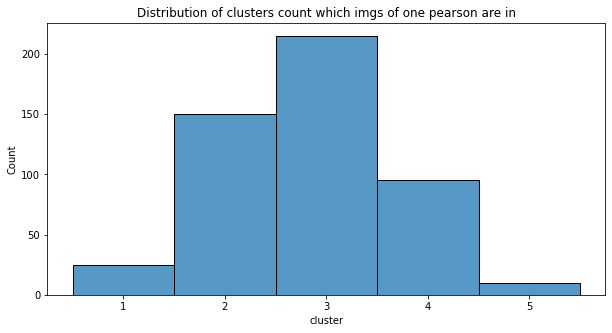

In [122]:
fig = plt.figure(figsize=(10., 5.))
ax = sns.histplot(data=persons_in_clusters, x="cluster", discrete=True)
_ = ax.set_title("Distribution of clusters count which imgs of one pearson are in")

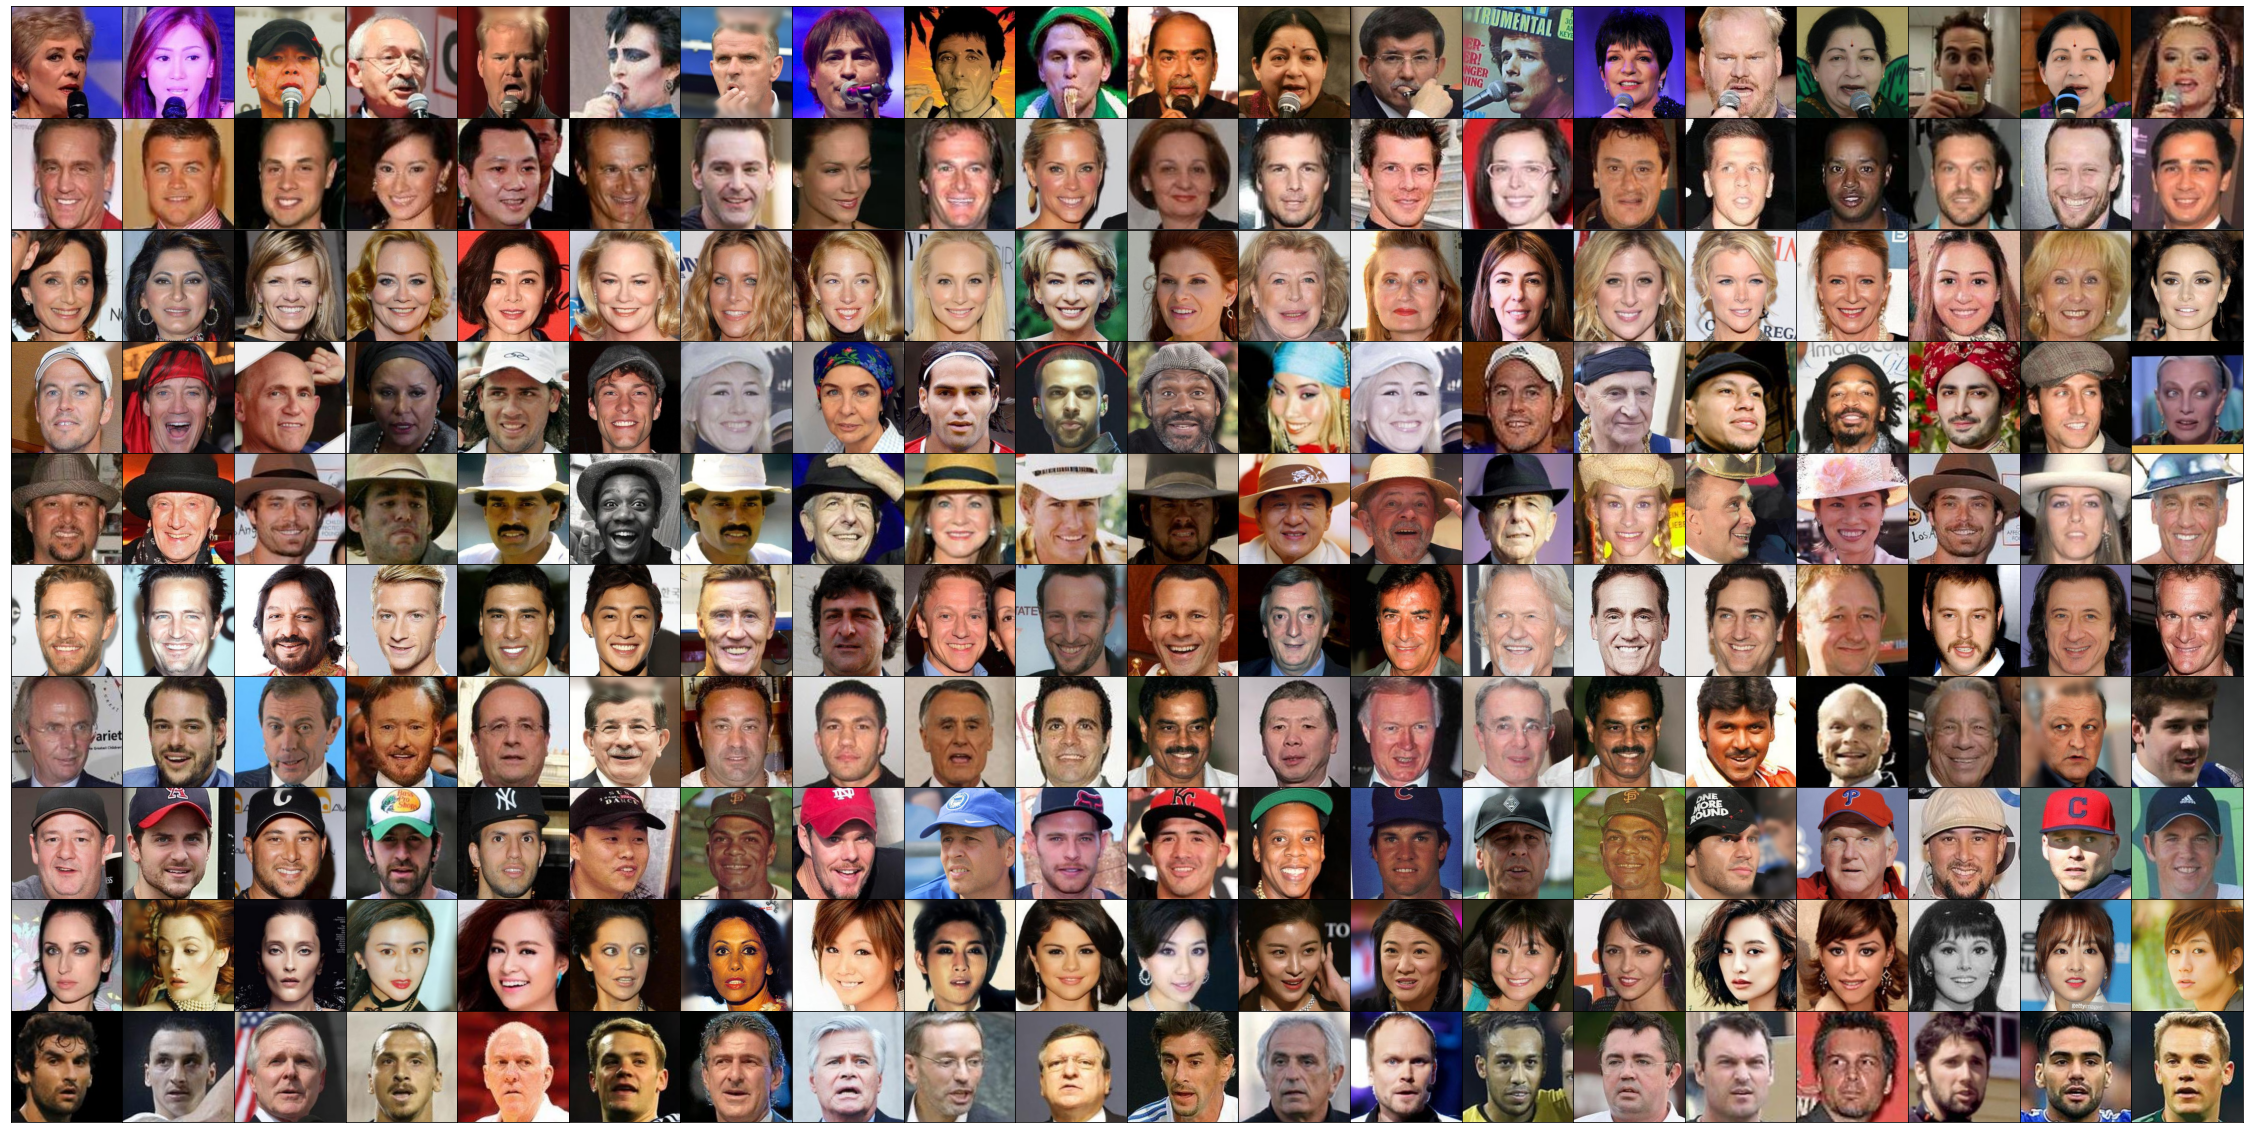

In [123]:
clusters = sorted(list(plot_data.cluster.unique()))
ROWS = len(clusters)
COLS = 20

fig = plt.figure(figsize=(40., 30.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(ROWS, COLS),
                 axes_pad=0,  # pad between axes in inch.
                 share_all=True,
                 )
grid[0].get_yaxis().set_ticks([])
grid[0].get_xaxis().set_ticks([])

imgs = []
for cluster in clusters:
    cluster_imgs = plot_data[plot_data.cluster == cluster]
    for img_path in cluster_imgs.head(COLS).img_path:
        img = Image.open(img_path)
        imgs.append(plt.imread(img_path))

for ax, im in zip(grid, imgs):
    ax.imshow(im)

Find "good" clusters, which have persons with all imagens in the same cluster

In [127]:
persons_all_in_one = persons_in_clusters[persons_in_clusters.cluster == 1].index.tolist()
good_clusters = imgs_df[imgs_df.person.isin(persons_all_in_one)].cluster.unique()
f"Good clusters: {sorted(list(good_clusters))}"

'Good clusters: [2, 5, 7, 8, 9]'

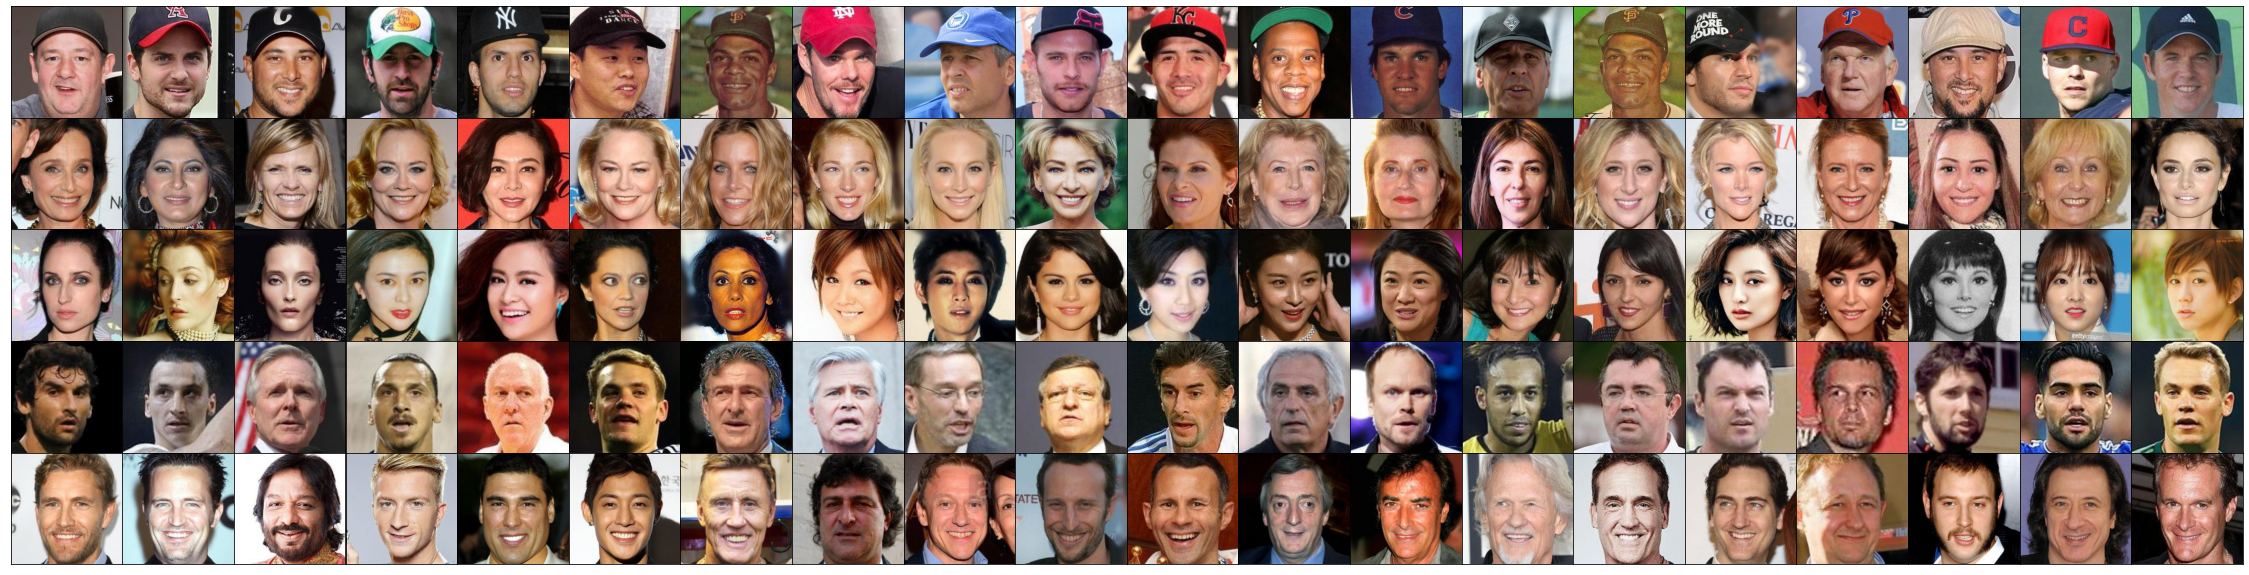

In [125]:
clusters = sorted(list(plot_data.cluster.unique()))
ROWS = len(good_clusters)
COLS = 20

fig = plt.figure(figsize=(40., 30.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(ROWS, COLS),
                 axes_pad=0,  # pad between axes in inch.
                 share_all=True,
                 )
grid[0].get_yaxis().set_ticks([])
grid[0].get_xaxis().set_ticks([])

imgs = []
for cluster in good_clusters:
    cluster_imgs = plot_data[plot_data.cluster == cluster]
    for img_path in cluster_imgs.head(COLS).img_path:
        img = Image.open(img_path)
        imgs.append(plt.imread(img_path))

for ax, im in zip(grid, imgs):
    ax.imshow(im)

#### Clusters plot using PCA

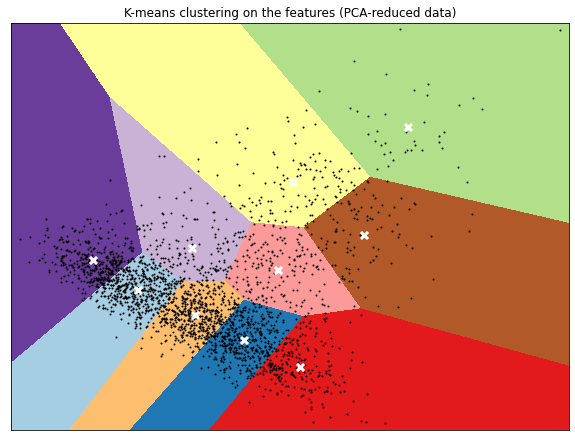

In [128]:
reduced_data = PCA(n_components=2).fit_transform(features)
kmeans = KMeans(n_clusters=CLUSTERS, init='k-means++', max_iter=300, n_init=10, algorithm='elkan')
_ = kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = 0.02  # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
fig = plt.figure(1, figsize=(10., 7.5))
plt.clf()
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",
)

plt.plot(reduced_data[:, 0], reduced_data[:, 1], "k.", markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=50,
    linewidths=3,
    color="w",
    zorder=10,
)
plt.title(
    "K-means clustering on the features (PCA-reduced data)"
)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()